## QRT Data Challenge: Can you explain the price of electricity?

#### Import Packages

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
PLOT_COLOR = "tab:orange"

from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV
from sklearn.metrics import root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import spearmanr

import optuna

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

### Plotting and Metric Score: Spearman Correlation (Rank)

In [28]:
def plot_ts(ts_x: pd.Series, ts_y: pd.Series, title: str = None, figsize=(13, 5)) -> None:
    """plots a given timeseries and displays an optional title"""
    plt.figure(figsize=figsize)
    plt.plot(ts_x, ts_y)
    plt.title(title or '', fontsize=10)
    plt.grid(alpha=0.5, linestyle='dashed')
    plt.show()

def plot_ts_y(ts_x, ts_y, title: str = None, figsize=(13, 5)) -> None:
    plt.figure(figsize=figsize)
    plt.plot(ts_x, label=ts_x)
    plt.plot(ts_y, label=ts_y)
    plt.title(title or '', fontsize=10)
    plt.grid(alpha=0.5, linestyle='dashed')
    plt.show()

def metric_train(output, Y_clean):
    return 100 * (spearmanr(output, Y_clean).correlation)

### Data Preprocessing

In [29]:
# Importing Data From Files
X = pd.read_csv("X_train.csv")
y = pd.read_csv("y_train.csv")
x_val = pd.read_csv("X_test.csv")

In [30]:
X.head()

,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
0,1054,206,FR,0.210099,-0.427458,-0.606523,0.606523,NaN,0.692860,NaN,...,-0.444661,-0.172680,-0.556356,-0.790823,-0.283160,-1.069070,-0.063404,0.339041,0.124552,-0.002445
1,2049,501,FR,-0.022399,-1.003452,-0.022063,0.022063,-0.573520,-1.130838,0.573520,...,-1.183194,-1.240300,-0.770457,1.522331,0.828412,0.437419,1.831241,-0.659091,0.047114,-0.490365
2,1924,687,FR,1.395035,1.978665,1.021305,-1.021305,-0.622021,-1.682587,0.622021,...,1.947273,-0.480700,-0.313338,0.431134,0.487608,0.684884,0.114836,0.535974,0.743338,0.204952
3,297,720,DE,-0.983324,-0.849198,-0.839586,0.839586,-0.270870,0.563230,0.270870,...,-0.976974,-1.114838,-0.507570,-0.499409,-0.236249,0.350938,-0.417514,0.911652,-0.296168,1.073948
4,1101,818,FR,0.143807,-0.617038,-0.924990,0.924990,NaN,0.990324,NaN,...,-0.526267,-0.541465,-0.424550,-1.088158,-1.011560,0.614338,0.729495,0.245109,1.526606,2.614378


In [31]:
y.head()

,ID,TARGET
0,1054,0.028313
1,2049,-0.112516
2,1924,-0.180840
3,297,-0.260356
4,1101,-0.071733


Amount of Data for each country varies!

In [32]:
X['COUNTRY'].value_counts()

COUNTRY
FR    851
DE    643
Name: count, dtype: int64

### Missing Data: Use Interpolation

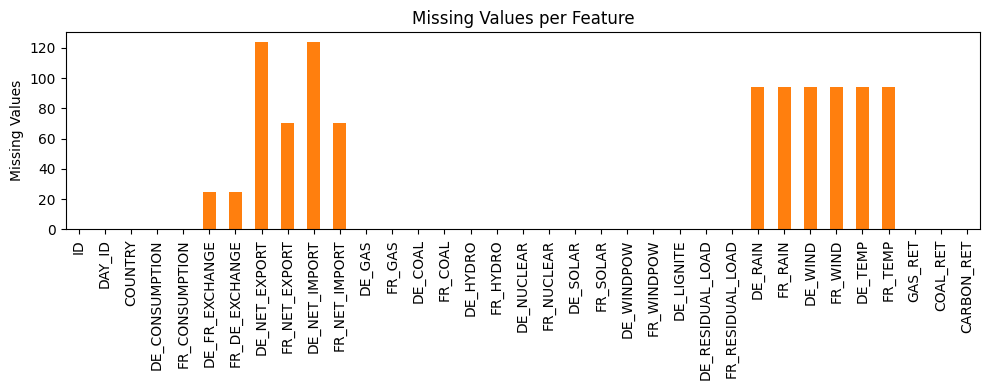

In [33]:
missing_vals = X.isna().sum()
missing_vals.plot(kind='bar', figsize=(10, 4), color=PLOT_COLOR)
plt.title('Missing Values per Feature')
plt.ylabel('Missing Values')
plt.xticks(rotation=90)  # Rotate the x labels to show them vertically
plt.tight_layout()  # Adjust layout to make room for the x labels
plt.show()

#### Fill Missing Data with interpolation

In [8]:
X.interpolate(method='polynomial', order=3, inplace=True)
X = X.fillna(0)
X = X.drop(['COUNTRY'], axis=1)

x_val.interpolate(method='polynomial', order=3, inplace=True)
x_val = x_val.fillna(0)
x_val = x_val.drop(['COUNTRY'], axis=1)

Verify that all missing data has been filled by interpolation

In [9]:
missing_vals = X.isna().sum()
print(f'We have {missing_vals.sum()} missing values left!')

We have 0 missing values left!


### Investigation: Which features are relevant?

In [18]:
def get_feature_corr_with_target_and_plot(X, y, figsize=(12, 6)):
    correlation = [metric_train(X[col], y['TARGET']) for col in X.columns]
    correlation_df = pd.DataFrame(correlation, index=X.columns, columns=['Features'])
    plt.figure(figsize=figsize)
    correlation_df.sort_values(by='Features').plot(kind='bar', figsize=figsize, color=PLOT_COLOR)
    plt.title('Correlation(Features, Target Variable)')
    plt.ylabel('Correlation Coefficient [%]')
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.show()

    return correlation_df

<Figure size 1200x600 with 0 Axes>

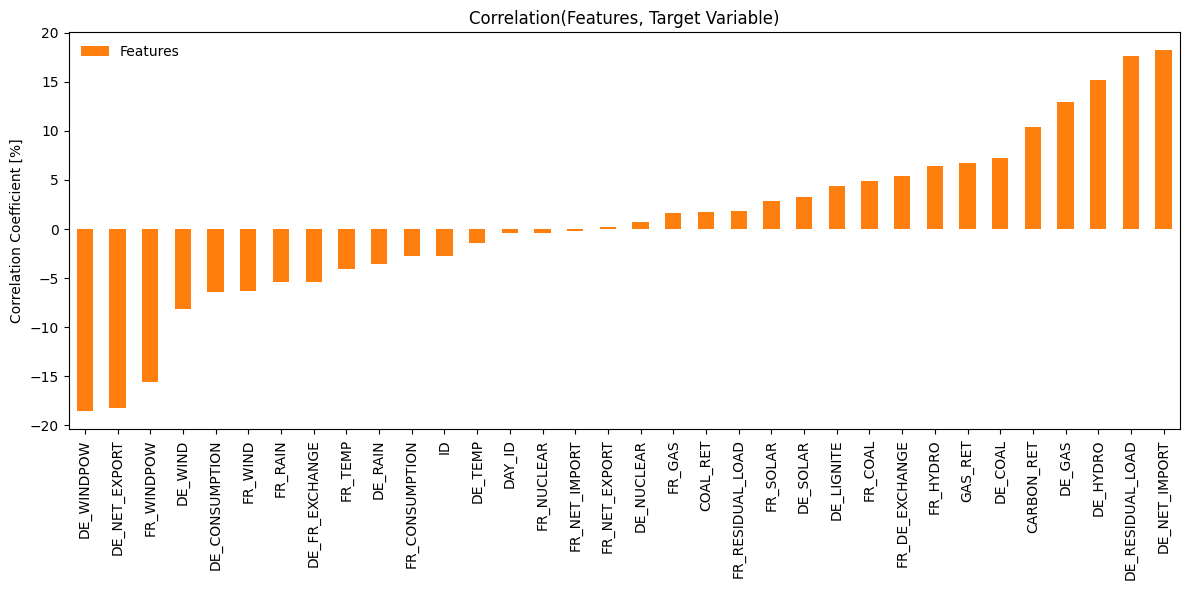

In [19]:
correlation_df = get_feature_corr_with_target_and_plot(X, y)

Define a correlation threshold for which features below it are not being considered *impactful/relevant* for the target variable and can therefore be dropped to simplify the model

In [22]:
correlation_threshold = 1.5
low_corr_features = correlation_df[abs(correlation_df['Features']) < correlation_threshold].index.to_list()
low_corr_features

['DAY_ID',
 'FR_NET_EXPORT',
 'FR_NET_IMPORT',
 'DE_NUCLEAR',
 'FR_NUCLEAR',
 'DE_TEMP']

In [23]:
country_cols = ['COUNTRY_DE', 'COUNTRY_FR']
columns_to_drop = [feat for feat in low_corr_features if feat not in country_cols]
X_cleaned = X.drop(columns=columns_to_drop)

<Figure size 1200x600 with 0 Axes>

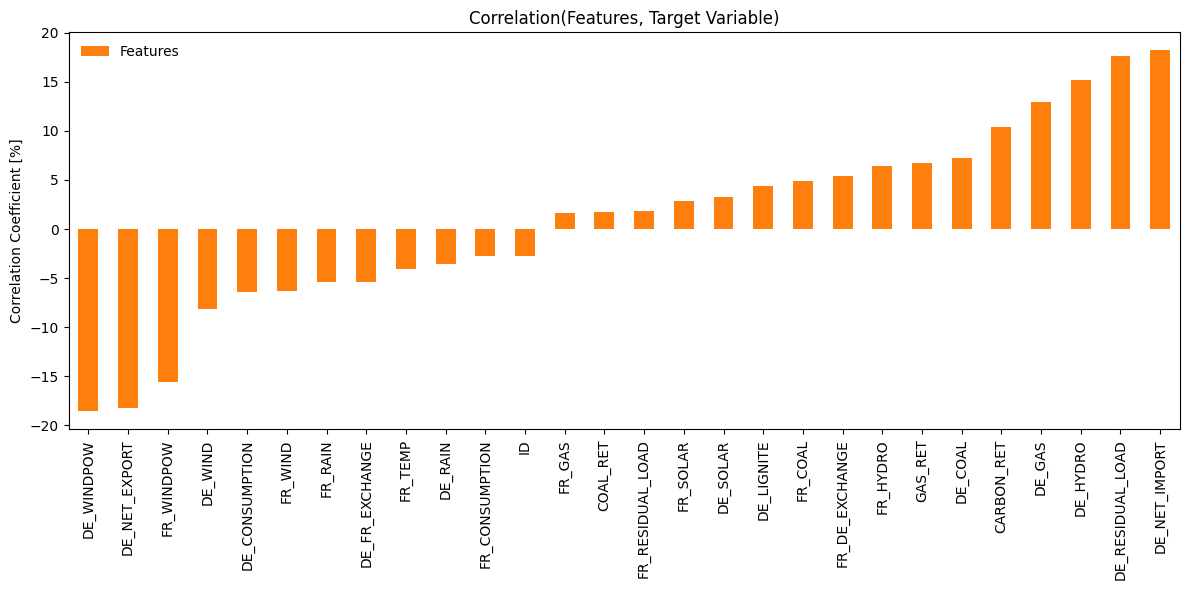

In [ ]:
new_corr_df = get_feature_corr_with_target_and_plot(X_cleaned, y)

Remaining features after cleaning

In [25]:
new_corr_df.sort_values(by='Features', inplace=True)
new_corr_df

,Features
DE_WINDPOW,-18.568799
DE_NET_EXPORT,-18.200552
FR_WINDPOW,-15.556754
DE_WIND,-8.110643
DE_CONSUMPTION,-6.361683
FR_WIND,-6.329550
FR_RAIN,-5.435784
DE_FR_EXCHANGE,-5.400954
FR_TEMP,-4.105975
DE_RAIN,-3.605381


---

# Cross Validation for MSE using XGBRegressor

In [ ]:
def XGBRegressorCrossValidationMSE(X_clean, Y_clean):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X_clean, Y_clean, test_size=0.10, random_state=42)

    # Define the parameter grid
    param_grid = {
        'max_depth': [3, 6, 10],  # LightGBM's 'num_leaves' can be roughly translated to 'max_depth' in XGBoost
        'reg_alpha': [0.1, 0.2, 0.3],  # LightGBM's 'bagging_fraction' does not have a direct equivalent, but 'reg_alpha' can help with regularization
        'n_estimators': [100],  # Reduced number of options for 'n_estimators' to speed up the process
        'learning_rate': [0.05, 0.1, 0.2],  # Same as LightGBM's
        'colsample_bytree': [0.6, 0.8, 0.9],  # Similar to LightGBM's 'feature_fraction'
        'subsample': [0.6, 0.8, 0.9]  # Similar to LightGBM's 'bagging_fraction'
    }

    # Initialize the XGBRegressor
    xgb_reg = XGBRegressor(booster='gbtree', objective='reg:squarederror')
    # Create a GridSearchCV object
    grid_search = GridSearchCV(
        estimator=xgb_reg,
        param_grid=param_grid,
        cv=5,
        scoring='neg_root_mean_squared_error',
        return_train_score=True,
        n_jobs=-1,
        verbose=2
    )

    # Perform grid search
    grid_search.fit(X_train, y_train)

    # Results
    best_parameters = grid_search.best_params_
    best_mse = -1 * grid_search.best_score_
    best_model = grid_search.best_estimator_
    y_pred_train = cross_val_predict(best_model, X_train, y_train, cv=5)
    spearman_corr = 100 * spearmanr(y_pred_train, y_train).correlation
    y_pred_test = best_model.predict(X_test)
    mse_test = root_mean_squared_error(y_test, y_pred_test)

    # Output the best parameters and corresponding mean square error
    print("Best parameters found: ", grid_search.best_params_)
    print("Best MSE: ", best_mse)
    print("Spearman correlation on training data: ", spearman_corr)
    print("MSE on test data: ", mse_test)

    # Prepare the result dictionary
    result = {
        "model": best_model,
        "best_parameters": best_parameters,
        "best_mse": best_mse,
        "mse_test": mse_test,
        "spearman_correlation_train": spearman_corr
    }
    return result

# LightGBM model

#### Optuna HPO

In [ ]:
def objective(trial, X_train, y_train):
    # Define the hyperparameter search space for Optuna
    param_grid = {
        'num_leaves': trial.suggest_int('num_leaves', 10, 70),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5, log=True),
        'feature_fraction': trial.suggest_categorical('feature_fraction', [0.5, 0.6, 0.7, 0.8, 0.9]),
        'bagging_fraction': trial.suggest_categorical('bagging_fraction', [0.5, 0.6, 0.7, 0.8, 0.9]),
        'bagging_freq': trial.suggest_int('bagging_freq', 2, 10),
    }
    
    # Initialize the LightGBM model with the sampled hyperparameters
    lgbm = LGBMRegressor(boosting_type='gbdt', objective='regression', metric='mse', **param_grid)
    
    # Perform cross-validation and use the average MSE as the optimization metric
    y_pred_train = cross_val_predict(lgbm, X_train, y_train, cv=5)
    mse = root_mean_squared_error(y_train, y_pred_train)
    
    return mse  # Minimize the mean squared error

def LGBRegressorOptuna(X_clean, Y_clean):
    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_clean, Y_clean, test_size=0.10, random_state=42)

    # Create an Optuna study and optimize the objective function
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=100)

    # Get the best hyperparameters and build the final model
    best_params = study.best_params
    best_model = LGBMRegressor(boosting_type='gbdt', objective='regression', metric='mse', **best_params)
    best_model.fit(X_train, y_train)
    
    # Cross-validation predictions
    y_pred_train = cross_val_predict(best_model, X_train, y_train, cv=5)
    spearman_corr = spearmanr(y_pred_train, y_train).correlation * 100

    # Test set predictions
    y_pred_test = best_model.predict(X_test)
    mse_test = root_mean_squared_error(y_test, y_pred_test)

    # Print results
    print("Best parameters found: ", best_params)
    print("Best Spearman correlation (train):", spearman_corr)
    print("MSE on test data: ", mse_test)

    result = {
        "parameters": best_params,
        "model": best_model,
        "Test MSE": mse_test,
        "Metric Score": spearman_corr
    }
    return result

In [ ]:
X_clean = X.iloc[:, 2:] # X_clean should not have the ID column
#X_clean = X_cleaned
Y_clean = y['TARGET']

result = LGBRegressorOptuna(X_clean, Y_clean)

In [ ]:
def LGBRegressorCrossValidationMSE(X_clean, Y_clean):

    X_train, X_test, y_train, y_test = train_test_split(X_clean, Y_clean, test_size=0.10, random_state=42)

    param_grid = {
        'num_leaves': [10, 15, 31, 50, 70],
        'learning_rate': [0.015, 0.05, 0.1, 0.2],
        'feature_fraction': [0.6, 0.8, 0.9],
        'bagging_fraction': [0.6, 0.8, 0.9],
        'bagging_freq': [3, 5, 7],
        'max_depth': [5, 10, 15],
        'min_data_in_leaf': [20, 50, 100],
        'lambda_l1': [0, 0.1, 1],
        'lambda_l2': [0, 0.1, 1]
    }

    # build the LightGBM model
    lgbm = LGBMRegressor(boosting_type='gbdt', objective='regression', metric='mse')
    # build the GridSearchCV on LightGBM
    grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
    # grid search
    grid_search.fit(X_train, y_train)
    
    # results
    best_parameters = grid_search.best_params_
    best_mse = -1 * grid_search.best_score_
    best_model = grid_search.best_estimator_
    y_pred_train = cross_val_predict(best_model, X_train, y_train, cv=5)
    spearman_corr = metric_train(y_pred_train, y_train)
    # calculate the target test data
    y_pred_test = best_model.predict(X_test)
    # Calculate MSE for test data
    mse_test = root_mean_squared_error(y_test, y_pred_test)

    # Print Results
    print("Best parameters found: ", best_parameters)
    print("Best mse: ", best_mse)
    print("Best Spearman correlation:", spearman_corr)
    print("MSE on test data: ", mse_test)

    result = {
        "parameters": best_parameters,
        "model":best_model,
        "Best MSE": best_mse,
        "Test MSE":mse_test,
        "Metric Score": spearman_corr
    }
    return result

# Random Forest Model

In [ ]:
def RandomForestRegressorCrossValidationMSE(X_clean, Y_clean):
    
    # X_clean and Y_clean must be processed already
    X_train, X_test, y_train, y_test = train_test_split(X_clean, Y_clean, test_size=0.10, random_state=42)

    # Define parameter grid
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 15],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    rf_reg = RandomForestRegressor(random_state=42)

    # GridSearchCV with the scoring minimizing MSE
    cv_method = GridSearchCV(estimator=rf_reg, param_grid=param_grid, cv=5,
                             scoring='neg_root_mean_squared_error', verbose=2, n_jobs=-1)
    cv_method.fit(X_train, y_train)

    # Best parameters
    print("Best parameters found: ", cv_method.best_params_)

    # Predict on the test set with the best parameters
    y_pred = cv_method.predict(X_test)

    # Calculate MSE on the test set and then convert to RMSE
    mse = root_mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print('Test set RMSE: {:.2f}'.format(rmse))

    training_prediction = cv_method.predict(X_clean)

    print('Cross Validated Model MSE for the train set: {:.2f}'.format(root_mean_squared_error(training_prediction, Y_clean)))

    result = {
        "parameters": cv_method.best_params_,
        "RMSE": rmse,
        "Training Prediction": training_prediction,
        "Metric Score": root_mean_squared_error(training_prediction, Y_clean),
        "model": cv_method
    }
    return result

In [ ]:
X_clean = X.iloc[:, 2:] # X_clean should not have the ID column
#X_clean = X_cleaned
Y_clean = y['TARGET']

#### Running the Light GBM Model 

In [ ]:
CV_LGBM = LGBRegressorCrossValidationMSE(X_clean=X_clean, Y_clean=Y_clean)

In [ ]:
# Running the LightGBM Model
light_gbm_submission = x_val[['ID']].copy()
x_val_clean = x_val.iloc[:, 2:]
light_gbm_submission['TARGET'] = CV_LGBM['model'].predict(x_val_clean)
light_gbm_submission.to_csv('light_gbm_submission.csv', index=False)

In [ ]:
lgbm_feature_importances = CV_LGBM['model'].feature_importances_
lgbm_importances = pd.Series(lgbm_feature_importances, index=X_clean.columns)
lgbm_importances = lgbm_importances.sort_values()
lgbm_importances.plot(kind='bar', figsize=(10,5))
plt.title('Feature Importance for Light GBM Model')
plt.show()

# Running the XGBoost Regression

In [ ]:
CV_XGB = XGBRegressorCrossValidationMSE(X_clean=X_clean, Y_clean=Y_clean)

Best parameters found:  {'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0.1, 'subsample': 0.9}

In [ ]:
# Running the XGB Model
xgb_submission = x_val[['ID']].copy()
x_val_clean = x_val.iloc[:, 2:]
xgb_submission['TARGET'] = CV_XGB['model'].predict(x_val_clean)
xgb_submission.to_csv('submission_files/xgb_submission.csv', index=False)

In [ ]:
xgb_feature_importances = CV_XGB['model'].feature_importances_
xgb_importances = pd.Series(xgb_feature_importances, index=X_clean.columns)
xgb_importances = xgb_importances.sort_values()
xgb_importances.plot(kind='bar', figsize=(10,3))
plt.title('Feature Importance for XGB Model')
plt.show()

In [ ]:
plt.plot(light_gbm_submission['TARGET'], label='LGBM')
plt.plot(xgb_submission['TARGET'], label='XGB')
plt.legend()
metric_train(light_gbm_submission['TARGET'], xgb_submission['TARGET'])

# Running the Random Forest Model

In [ ]:
CV_RF_MSE = RandomForestRegressorCrossValidationMSE(X_clean=X_clean, Y_clean=Y_clean)

In [ ]:
# Running the XGB Model
rf_submission = x_val[['ID']].copy()
x_val_clean = x_val.iloc[:, 2:]
rf_submission['TARGET'] = CV_RF_MSE['model'].predict(x_val_clean)
rf_submission.to_csv('submission_files/rf_submission.csv', index=False)

# Comparison of Target Predictions between Models

In [ ]:
# Simple Model
xgb= XGBRegressor(objective='reg:squarederror', )
xgb.fit(X_clean, Y_clean)
predictions = xgb.predict(X_clean)
y = y.sort_index()
predictions_df = pd.DataFrame(predictions, index=y.index)
print(metric_train(predictions, Y_clean))

plt.figure(figsize=(10,4))
plt.plot(y['TARGET'], label='y_true')
plt.plot(predictions_df, label='predictions')
plt.legend()
plt.title("Comparing True Training Values with No Cross Validated XGB Model")
print("Model parameters:", xgb.get_params())

In [ ]:
# Comparing Training Preditions with CV XGB Model
lgbm_predictions = CV_LGBM['model'].predict(X_clean)
xgb_predictions = CV_XGB['model'].predict(X_clean)
rf_predictions = CV_RF_MSE['model'].predict(X_clean)
plt.figure(figsize=(10, 4))
plt.plot(y['TARGET'], label='y_train')
plt.plot(lgbm_predictions, label='LGBM Predictions')
plt.plot(xgb_predictions, label='XGB Predictions')
plt.plot(xgb_predictions, label='RF Predictions')
plt.legend()
plt.title("Comparing True Training Predictions with ML Models")
print(metric_train(lgbm_predictions, Y_clean))
print(metric_train(rf_predictions, Y_clean))

In [ ]:
plt.figure(figsize=(10,3))
plt.plot(light_gbm_submission['TARGET'], label='LGBM Predictions')
plt.plot(xgb_submission['TARGET'], label='XGB Predictions')
plt.plot(rf_submission['TARGET'], label='RF Predictions')
plt.legend()
plt.title("Out of Sample Predictions")

In [ ]:
print("The Volatiltity of LGBM Predictions: ", np.std(light_gbm_submission['TARGET']))
print("The Volatiltity of XGB Predictions: ", np.std(xgb_submission['TARGET']))
print("The Volatiltity of RF Predictions: ", np.std(rf_submission['TARGET']))
print("The Volatiltity of Training Target Variable: ", np.std(y['TARGET']))